# Data analysis project: **Vehicle energy comsumption**
### - On three different driving cycles, two different cars, hybrid and non-hybrid propulsion

This is a little, very simple *enginnering and data analysis project*.  
We will analyze some driving cycles used on emissions and compsumption certification.  
Then we will use some hypothetical cars and analyze their power and energy comsumption on each of these driving cycles.  
Last, we will consider the same cars as being hybrid, make the same analysis for them and compare the results.

In [146]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

We will use three different driving cycles used for light vehicles:
- FTP75 is used on USA
- WLTC is used in Europe
- JC08 is used in Japan

Let's import and format each driving cycle, then merge them in a single table (Pandas DataFrame) for doing our ploting and calculations later:

In [147]:
#read and format FTP75:

ftp = pd.read_csv('FTP75.csv', header=1, index_col='s')
#it is in mph, lets transform the mph collumn to km/h:
ftp = ftp[['mph']]*1.60934
ftp.rename(columns={'mph': 'km/h'}, inplace=True)
ftp['cycle'] = 'FTP'
ftp.reset_index(inplace=True)

#read and format WLTC:

wltc = pd.read_csv('WLTC.csv', header=1)
wltc['cycle'] = 'WLTC'

#read and format JC08:

jc = pd.read_csv('JC08.csv', header=1)
jc[['s', 'km/h', 'A', 'B', 'C']] = jc['s km/h A B C'].str.split(expand=True)
jc.drop(columns=['s km/h A B C', 'Unnamed: 1', 'A', 'B', 'C'], inplace=True)
jc['cycle'] = 'JC08'
jc['s'] = jc['s'].astype(int)
jc['km/h'] = jc['km/h'].astype(float)

#merging the cycles:

df = pd.concat([ftp, wltc, jc], ignore_index=True) #merging the cycles
df = df[['cycle', 's', 'km/h']] #rearrange the columns' order
# Now we have one single dataframe with the second-by-second speed of each cycle


---

## Some basic enginnering

Let's calculate the accelaration for each second.
For math simplicity we will use the slope of the line from the previous to the next point:

> acceleration(p) = ( speed(p+1) - speed(p-1) ) / 2

In [148]:
df['prev'] = df['km/h'].shift(1)
df['next'] = df['km/h'].shift(-1)
df.fillna(0, inplace=True)
df['m/s2'] = (df['next']/3.6 - df['prev']/3.6) / 2
df.drop(columns=['prev', 'next'], inplace=True)
df

,cycle,s,km/h,m/s2
0,FTP,0,0.0,0.000000
1,FTP,1,0.0,0.000000
2,FTP,2,0.0,0.000000
3,FTP,3,0.0,0.000000
4,FTP,4,0.0,0.000000
...,...,...,...,...
4552,JC08,1200,14.2,-0.833333
4553,JC08,1201,10.7,-1.041667
4554,JC08,1202,6.7,-1.000000
4555,JC08,1203,3.5,-0.930556


### Ploting the cycles:

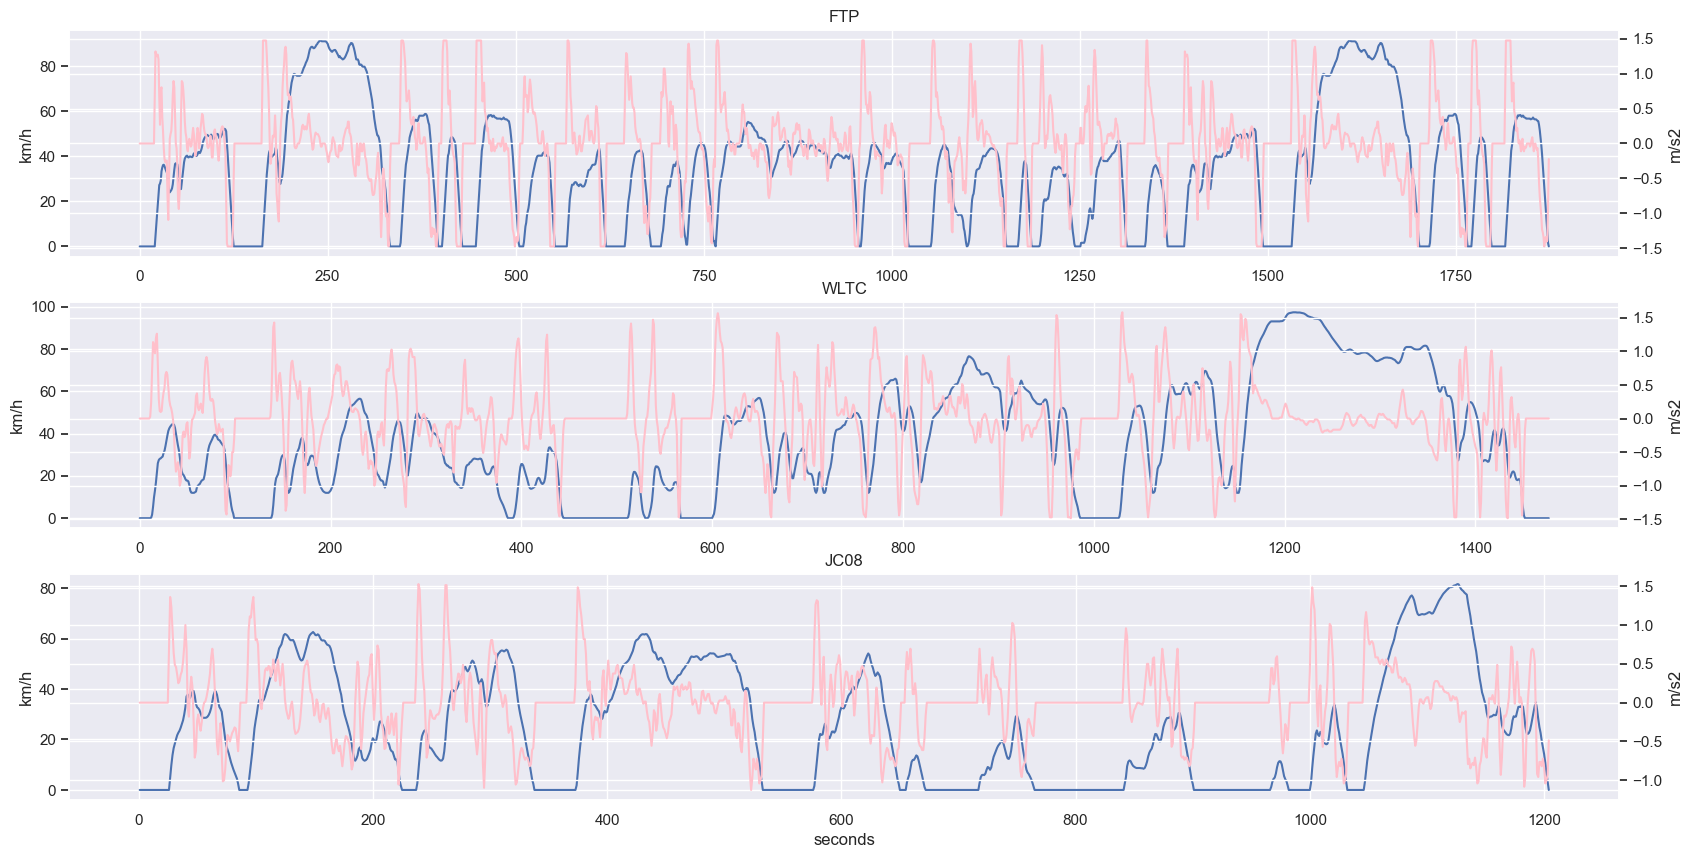

In [149]:
sns.set_theme() #using Seaborn's styles

figure, axis = plt.subplots(3, 1, figsize=(20,10)) #instantiating the matplotlib figure with 3x1 graphs
ax_acc = axis.copy() #for storing the acceleratioon graphs

for i, cycle in enumerate(df['cycle'].unique()):
    axis[i].plot(df.loc[df['cycle'] == cycle]['s'], df.loc[df['cycle'] == cycle]['km/h'], label='km/h') #speed graph
    axis[i].set_title(cycle)
    #axis[0].set_xlabel('seconds')
    axis[i].set_ylabel('km/h')
    ax_acc[i] = axis[i].twinx() #acceleration graph
    ax_acc[i].plot(df.loc[df['cycle'] == cycle]['s'], df.loc[df['cycle'] == cycle]['m/s2'], color='pink', label='m/s2')
    ax_acc[i].set_ylabel('m/s2')

axis[2].set_xlabel('seconds')

plt.show()

### We can get some statistics for the cycles, and plot it:

In [150]:
stats = df[["cycle", "km/h", "m/s2"]].groupby("cycle").describe().round(4).transpose()
stats = stats[df['cycle'].unique()] # correcting the order of the columns

# negative or zero acceleration have little to no impact on power usage. So let's make a column with only the positive acceleration
pos_acc = df[["cycle", "m/s2"]].loc[(df['m/s2'] > 0)].rename(columns={'m/s2': 'positive m/s2'}).groupby("cycle").describe().round(4).transpose()
pos_acc = pos_acc[df['cycle'].unique()] # correcting the order of the columns
stats = pd.concat([stats, pos_acc])
stats #here we have some interesting numbers... but not so easy to read... let's make it visual next!

cycle                      FTP       WLTC       JC08
km/h          count  1875.0000  1478.0000  1204.0000
              mean     34.1172    36.5560    24.4349
              std      25.6613    27.3307    23.0689
              min       0.0000     0.0000     0.0000
              25%      10.4607    14.9250     0.0000
              50%      36.2102    33.1000    20.5500
              75%      47.9583    56.2000    43.1000
              max      91.2496    97.4000    81.6000
m/s2          count  1875.0000  1478.0000  1204.0000
              mean     -0.0000    -0.0000    -0.0000
              std       0.6149     0.5417     0.4365
              min      -1.4752    -1.4861    -1.1250
              25%      -0.1565    -0.1944    -0.1944
              50%       0.0000     0.0000     0.0000
              75%       0.2235     0.2222     0.2083
              max       1.4752     1.5833     1.5278
positive m/s2 count   757.0000   611.0000   444.0000
              mean      0.4917     0.4391     0.3998
              std       0.4455     0.3893     0.3256
              min       0.0224     0.0139     0.0139
              25%       0.1341     0.1111     0.1528
              50%       0.3129     0.3056     0.3333
              75%       0.7376     0.6806     0.5313
              max       1.4752     1.5833     1.5278

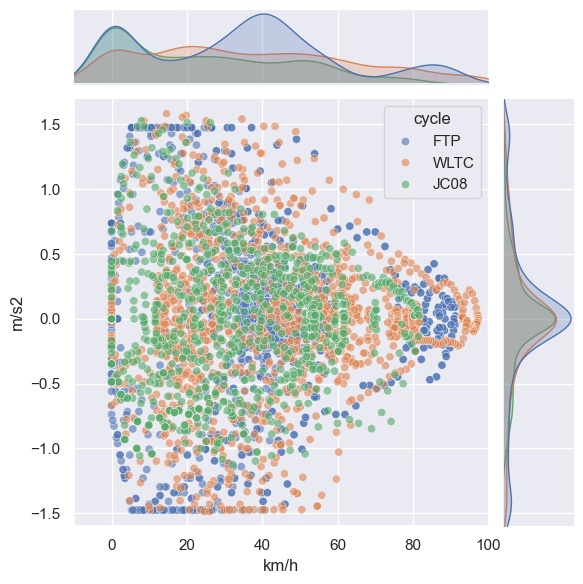

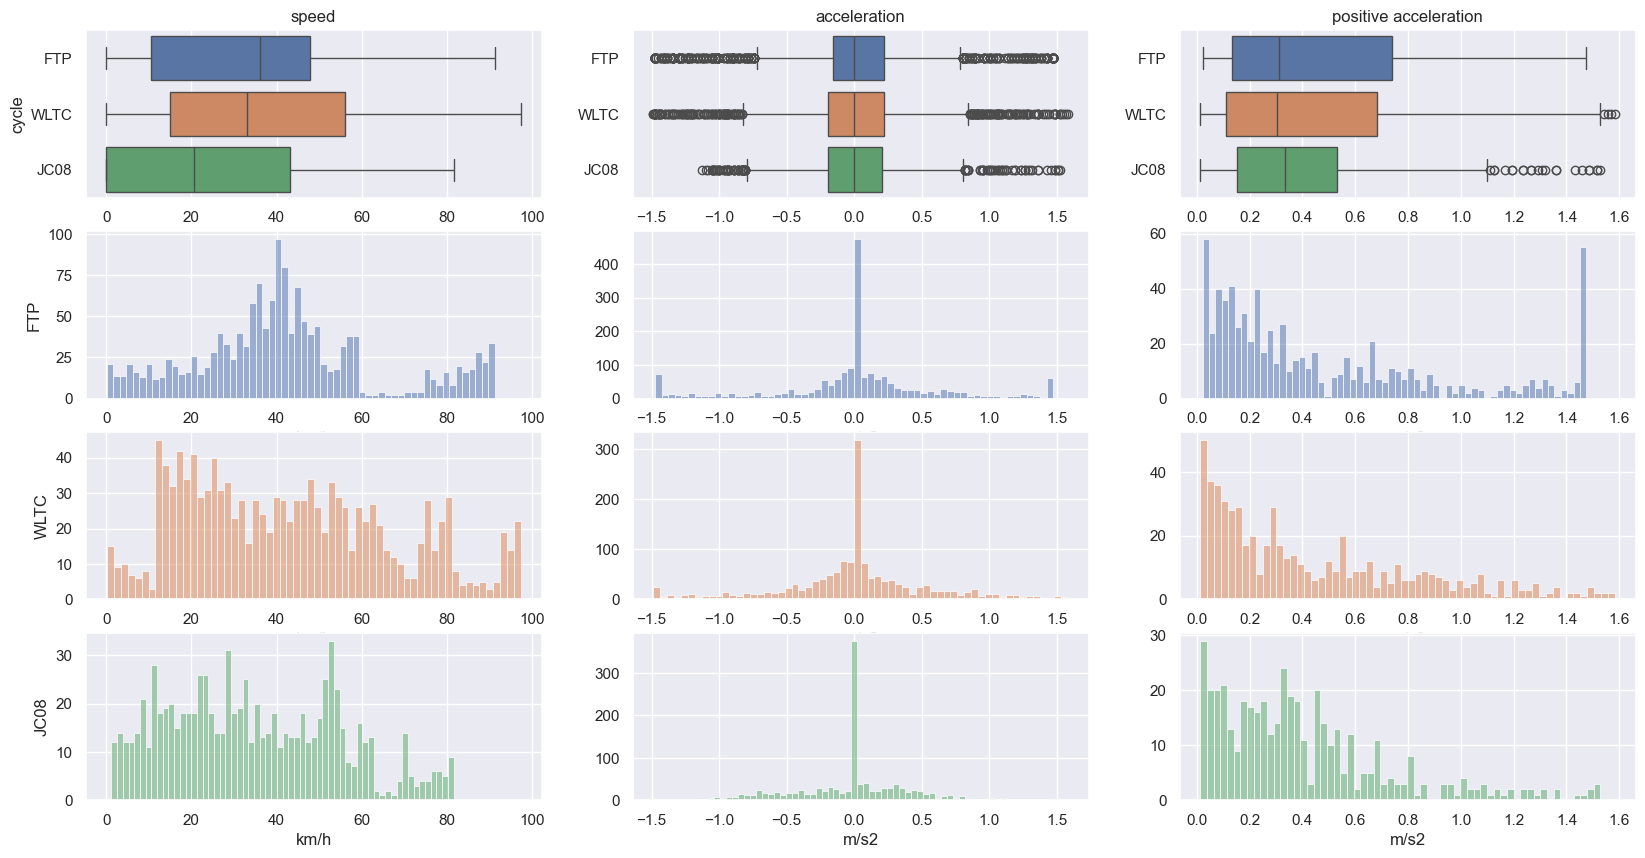

In [151]:
#Plotting some statistics for the cycles:

sns.jointplot(data=df, x="km/h", y="m/s2", hue='cycle', alpha=.6, xlim=(-10, 100), ylim=(-1.6, 1.7))

figure, axis = plt.subplots(4, 3, figsize=(20,10))

sns.boxplot(data=df, ax=axis[0, 0], x="km/h", y="cycle", hue='cycle')
axis[0, 0].set_title('speed')
sns.boxplot(data=df, ax=axis[0, 1], x="m/s2", y="cycle", hue='cycle')
axis[0, 1].set_title('acceleration')
axis[0, 1].set_ylabel("")
sns.boxplot(data=df.loc[df['m/s2'] > 0], ax=axis[0, 2], x="m/s2", y="cycle", hue='cycle', legend=False)
axis[0, 2].set_title('positive acceleration')
axis[0, 2].set_ylabel("")

for i, cycle in enumerate(df['cycle'].unique()):
    sns.histplot(data=df.loc[(df['cycle'] == cycle) & (df['km/h'] != 0)], x="km/h", ax=axis[i+1, 0], bins=60, hue=df['cycle'], legend=False)
    #in the speed plot have to remove the points where speed=0km/h, because their quantity makes the other bars too small
    axis[i+1, 0].set_ylabel(cycle)
    axis[i+1, 0].sharex(axis[0, 0])
    sns.histplot(data=df.loc[(df['cycle'] == cycle) ], x="m/s2", ax=axis[i+1, 1], bins=60, hue=df['cycle'], legend=False)
    axis[i+1, 1].set_ylabel("")
    axis[i+1, 1].sharex(axis[0, 1])
    sns.histplot(data=df.loc[(df['cycle'] == cycle) & (df['m/s2'] > 0)], x="m/s2", ax=axis[i+1, 2], bins=60, hue=df['cycle'], legend=False)
    axis[i+1, 2].set_ylabel("")
    axis[i+1, 2].sharex(axis[0, 2])

### Speed:

- FTP gives more focus to the 30-50km/h window.
- WMTC have a more uniform distribution, and goes up to a slight higher max speed.
- JC08 have slower speeds overall and lower max speed.

### Acceleration:

- All cycles have predominance of soft accelerations, FTP have a slight higher number of high acceleration points.

---

## Adding a little vehicle engineering

Let's assume 2 different cars and try to estimate the total energy consumed by each one on each of the cycles.

### Assumptions and calculations:

Any time when *speed > 0*, the vehicle will face a **force** that is proportional to:
- it's *mass* (rolling resistance), plus
- the quadratic of it's *speed* (aerodynamic drag resistance).
> Fr[N] =       ( Frr[N] )         +                    ( Fd[N] )  
> Fr[N] = ( Crr * m[kg] * g[m/s^2] ) + ( 1/2 * AirDensity[kg/m^3] * Cd * FA[m^2] * S^2[(m/s)^2] )  
> Fr = ( Crr * m * 9.81 ) + ( 0.6125 * Cd * FA * S^2 )

Also, any time the *acceleration is > 0*, the vehicle is producing a **force** equal to it's *mass (in kg) multiplied by the acceleration (in m/s^2)*:
> Fa[N] = m[kg] * acc[m/s^2]

And the **power** (in Watts) needed to *overcome these resistances* and *accelerate* is the **sum of these forces** (in N) **multiplied by the speed** (in m/s).
> Pow[kW] = ( Fr[N] + Fa[N] ) * S[m/s]

So we will need to determine mass, Crr, Cd and frontal area for each of our theoretical vehicles.
Let's assume one mid-size sedan, and one mid-to-large SUV for our simulations. Typical values can be considered as follow:
- Sedan: m=1300kg, Crr=0.01, Cd=0.32, FA=2.2m^2
- SUV: m=2000kg, Crr=0.015, Cd=0.45, FA=2.7m^2

In [152]:
#creating a DataFrame with the car's specs:
cars = pd.DataFrame({
    'type':['Sedan', 'SUV'],
    'mass[kg]': [1300, 2000],
    'area[m2]': [2.2, 2.7],
    'Crr': [0.01, 0.015],
    'Cd': [0.32, 0.45]
}, index= ['Sedan', 'SUV'])
cars

,type,mass[kg],area[m2],Crr,Cd
Sedan,Sedan,1300,2.2,0.010,0.32
SUV,SUV,2000,2.7,0.015,0.45


Now, let's combine the *cycles* and the *cars* DataFrames, and calculate for each second:
- the resistive force each car is facing,
- the force required to have the specified acceleration,
- the total force,
- the demanded (+) or absorved (-) power (in kW).  
Adding each of these values in a new column.

In [153]:
temp = []
for i, car in enumerate(cars.index):
    temp.insert(i, df.copy())
    temp[i].insert(0, 'car', car)
    # Fr = ( Crr * m * 9.81 ) + ( 0.6125 * Cd * FA * S^2 )
    temp[i]['Fres[N]'] = (( cars.loc[car, 'Crr'] * cars.loc[car, 'mass[kg]'] * 9.81 ) +
    ( 0.6125 * cars.loc[car, 'Cd'] * cars.loc[car, 'area[m2]'] * temp[i]['km/h'] / 3.6 * temp[i]['km/h'] / 3.6 ))
    # Fa[N] = m[kg] * acc[m/s^2]
    temp[i]['Facc[N]'] = cars.loc[car, 'mass[kg]'] * temp[i]['m/s2']
    temp[i]['Ftot[N]'] = temp[i]['Fres[N]'] + temp[i]['Facc[N]']
    temp[i]['Pow[kW]'] = temp[i]['Ftot[N]'] * temp[i]['km/h'] / 1000

df2 = pd.concat(temp, ignore_index=True) #merging the dfs
df2

,car,cycle,s,km/h,m/s2,Fres[N],Facc[N],Ftot[N],Pow[kW]
0,Sedan,FTP,0,0.0,0.000000,127.530000,0.000000,127.530000,0.000000
1,Sedan,FTP,1,0.0,0.000000,127.530000,0.000000,127.530000,0.000000
2,Sedan,FTP,2,0.0,0.000000,127.530000,0.000000,127.530000,0.000000
3,Sedan,FTP,3,0.0,0.000000,127.530000,0.000000,127.530000,0.000000
4,Sedan,FTP,4,0.0,0.000000,127.530000,0.000000,127.530000,0.000000
...,...,...,...,...,...,...,...,...,...
9109,SUV,JC08,1200,14.2,-0.833333,305.878547,-1666.666667,-1360.788120,-19.323191
9110,SUV,JC08,1201,10.7,-1.041667,300.874230,-2083.333333,-1782.459103,-19.072312
9111,SUV,JC08,1202,6.7,-1.000000,296.877668,-2000.000000,-1703.122332,-11.410920
9112,SUV,JC08,1203,3.5,-0.930556,295.003418,-1861.111111,-1566.107693,-5.481377


> *Power* is:
> - POSITIVE when the vehicle is **using** power (for overcome the resistances and/or accelerate),
> - NEGATIVE when the vehicle is **braking** (for reduce speed according to the driving cycle)

*For energy comsumption, we shall only use the POSITIVE power values, as the negative ones are simply energy being wasted on the brakes.*

---

### Some stats and graph about power **consumption** (Pow>0) of each car on each cycle:

In [154]:
df2.loc[(df2['Pow[kW]'] > 0)][["car", "cycle", 'Pow[kW]']].groupby(['cycle', 'car'], sort=False).describe().round(4).transpose()

cycle                FTP                 WLTC                JC08          
car                Sedan        SUV     Sedan       SUV     Sedan       SUV
Pow[kW] count  1088.0000  1130.0000  853.0000  892.0000  528.0000  554.0000
        mean     22.8161    39.2162   25.1687   42.8578   19.9354   33.5357
        std      17.9398    29.2028   19.5408   32.1700   14.1301   23.6450
        min       0.0067     0.0905    0.0688    0.0169    0.0364    0.1444
        25%       9.0874    17.1536   10.1757   17.3667    8.2314   13.5215
        50%      18.7357    32.8340   21.2873   36.9643   17.5865   29.9394
        75%      31.6291    53.2326   35.9530   61.2429   29.3530   48.8747
        max     101.3841   162.2414  101.9500  163.9059   62.5994  103.8410

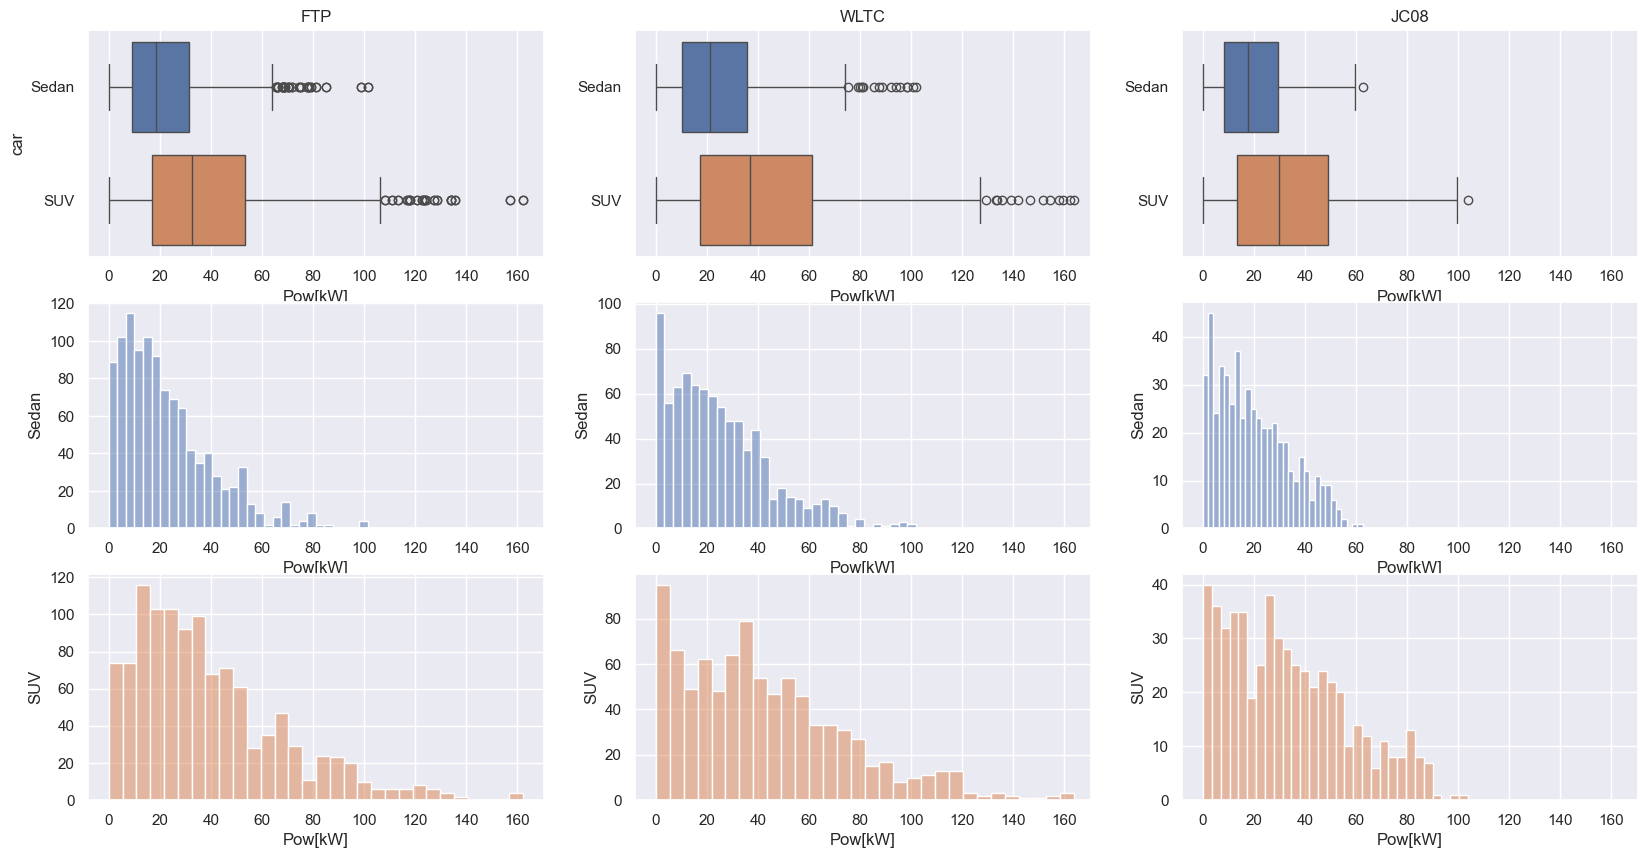

In [155]:
#plotting the (positive) power consumption of each car on each cycle:

figure, axis = plt.subplots(3, 3, figsize=(20,10))

for i, cycle in enumerate(df2['cycle'].unique()):
    sns.boxplot(data=df2.loc[(df2['cycle'] == cycle) & (df2['Pow[kW]'] > 0)], ax=axis[0, i], x="Pow[kW]", y="car", hue='car')
    axis[0, i].set_title(cycle)
    if i>0:
        axis[0, i].sharex(axis[0, 0])
        axis[0, i].set_ylabel('')
    
    for j, car in enumerate(df2['car'].unique()):
        sns.histplot(data=df2.loc[ (df2['cycle'] == cycle) & (df2['car'] == car) & (df2['Pow[kW]'] > 0) ], x="Pow[kW]", ax=axis[j+1, i], bins=30, hue=df2['car'], legend=False)
        axis[j+1, i].set_ylabel(car)
        axis[j+1, i].sharex(axis[0, 0])

plt.draw()

### Calculating the total energy consumed by each car on each cycle:

> E(MJ) = ( P(kW)/1000 * t(s) ) / 1e+06

In [156]:
energy = cars.copy()
for i, cycle in enumerate(df2['cycle'].unique()):
    for j, car in enumerate(df2['car'].unique()):
        energy.loc[car, cycle] = round((df2.loc[(df2['car'] == energy.index[j]) & (df2['cycle'] == cycle) & (df2['Pow[kW]'] > 0)]['Pow[kW]']*1000).sum()/1e+06, 2)

energy

,type,mass[kg],area[m2],Crr,Cd,FTP,WLTC,JC08
Sedan,Sedan,1300,2.2,0.010,0.32,24.82,21.47,10.53
SUV,SUV,2000,2.7,0.015,0.45,44.31,38.23,18.58


## Now let's introduce two HYBRID cars

Identical to the previous, but with hybrid electric propulsion (HEV).  

> On these cars, the NEGATIVE power will also be computed, as it is stored in the battery and not wasted in the brakes.

In [157]:
cars_HEV = pd.DataFrame({
    'type': ['Sedan', 'SUV'],
    'mass[kg]': [1300, 2000],
    'area[m2]': [2.2, 2.7],
    'Crr': [0.01, 0.015],
    'Cd': [0.32, 0.45],
    'hybrid': True
}, index= ['Sedan_HEV', 'SUV_HEV'])
cars['hybrid'] = False
cars2 = pd.concat([cars, cars_HEV]) #merging the cars
cars2

,type,mass[kg],area[m2],Crr,Cd,hybrid
Sedan,Sedan,1300,2.2,0.010,0.32,False
SUV,SUV,2000,2.7,0.015,0.45,False
Sedan_HEV,Sedan,1300,2.2,0.010,0.32,True
SUV_HEV,SUV,2000,2.7,0.015,0.45,True


### We will do again the calculations and plots including the hybrid cars:

In [158]:
#the power comsumption table including the hybrid cars:

temp = []
for i, car in enumerate(cars2.index):
    temp.insert(i, df.copy())
    temp[i].insert(0, 'car', car)
    temp[i].insert(1, 'type', cars2.loc[car, 'type'])
    temp[i].insert(2, 'hybrid', cars2.loc[car, 'hybrid'])
    # Fr = ( Crr * m * 9.81 ) + ( 0.6125 * Cd * FA * S^2 )
    temp[i]['Fres[N]'] = (( cars2.loc[car, 'Crr'] * cars2.loc[car, 'mass[kg]'] * 9.81 ) +
    ( 0.6125 * cars2.loc[car, 'Cd'] * cars2.loc[car, 'area[m2]'] * temp[i]['km/h'] / 3.6 * temp[i]['km/h'] / 3.6 ))
    # Fa[N] = m[kg] * acc[m/s^2]
    temp[i]['Facc[N]'] = cars2.loc[car, 'mass[kg]'] * temp[i]['m/s2']
    temp[i]['Ftot[N]'] = temp[i]['Fres[N]'] + temp[i]['Facc[N]']
    temp[i]['Pow[kW]'] = temp[i]['Ftot[N]'] * temp[i]['km/h'] / 1000

df3 = pd.concat(temp, ignore_index=True) #merging the cycles

df3.loc[(df3['hybrid'] == False) & (df3['Pow[kW]'] < 0), 'Pow[kW]'] = 0 #as non-hybrid cars can't retrieve the power
df3  #in this new table, when Pow>0 the power is being used by the vehicle; when Pow<0 the power is being retrieved (and stored in the battery)

,car,type,hybrid,cycle,s,km/h,m/s2,Fres[N],Facc[N],Ftot[N],Pow[kW]
0,Sedan,Sedan,False,FTP,0,0.0,0.000000,127.530000,0.000000,127.530000,0.000000
1,Sedan,Sedan,False,FTP,1,0.0,0.000000,127.530000,0.000000,127.530000,0.000000
2,Sedan,Sedan,False,FTP,2,0.0,0.000000,127.530000,0.000000,127.530000,0.000000
3,Sedan,Sedan,False,FTP,3,0.0,0.000000,127.530000,0.000000,127.530000,0.000000
4,Sedan,Sedan,False,FTP,4,0.0,0.000000,127.530000,0.000000,127.530000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
18223,SUV_HEV,SUV,True,JC08,1200,14.2,-0.833333,305.878547,-1666.666667,-1360.788120,-19.323191
18224,SUV_HEV,SUV,True,JC08,1201,10.7,-1.041667,300.874230,-2083.333333,-1782.459103,-19.072312
18225,SUV_HEV,SUV,True,JC08,1202,6.7,-1.000000,296.877668,-2000.000000,-1703.122332,-11.410920
18226,SUV_HEV,SUV,True,JC08,1203,3.5,-0.930556,295.003418,-1861.111111,-1566.107693,-5.481377


In [159]:
#some stats about power consumption of each car on each cycle:

df3[["type", "cycle", 'hybrid', 'Pow[kW]']].groupby(['cycle', 'type', 'hybrid'], sort=False).describe().round(4).transpose()

cycle                FTP                                        WLTC  \
type               Sedan                   SUV                 Sedan   
hybrid             False      True       False      True       False   
Pow[kW] count  1875.0000  1875.0000  1875.0000  1875.0000  1478.0000   
        mean     13.2394     8.1178    23.6343    16.5417    14.5257   
        std      17.7070    24.7453    29.7025    39.4828    19.3640   
        min      -0.0000   -76.4817    -0.0000  -112.5410     0.0000   
        25%       0.0000     0.0000     0.0000     0.0000     0.0000   
        50%       5.6071     5.6071    13.5289    13.5289     4.4520   
        75%      20.9512    20.9512    38.0130    38.0130    24.6815   
        max     101.3841   101.3841   162.2414   162.2414   101.9500   

cycle                                                JC08             \
type                            SUV                 Sedan              
hybrid             True       False      True       False      True    
Pow[kW] count  1478.0000  1478.0000  1478.0000  1204.0000  1204.0000   
        mean      9.2686    25.8654    18.7088     8.7424     5.1297   
        std      26.5478    32.6208    42.4720    13.6162    18.0113   
        min     -90.1479     0.0000  -132.3179    -0.0000   -58.5309   
        25%      -0.9883     0.0000     0.0000     0.0000    -0.9104   
        50%       4.4520    10.2104    10.2104     0.0000     0.0000   
        75%      24.6815    44.2815    44.2815    14.4180    14.4180   
        max     101.9500   163.9059   163.9059    62.5994    62.5994   

cycle                                
type                 SUV             
hybrid             False      True   
Pow[kW] count  1204.0000  1204.0000  
        mean     15.4309    10.6663  
        std      23.1648    28.8007  
        min      -0.0000   -84.1586  
        25%       0.0000     0.0000  
        50%       0.0000     0.0000  
        75%      27.2110    27.2110  
        max     103.8410   103.8410

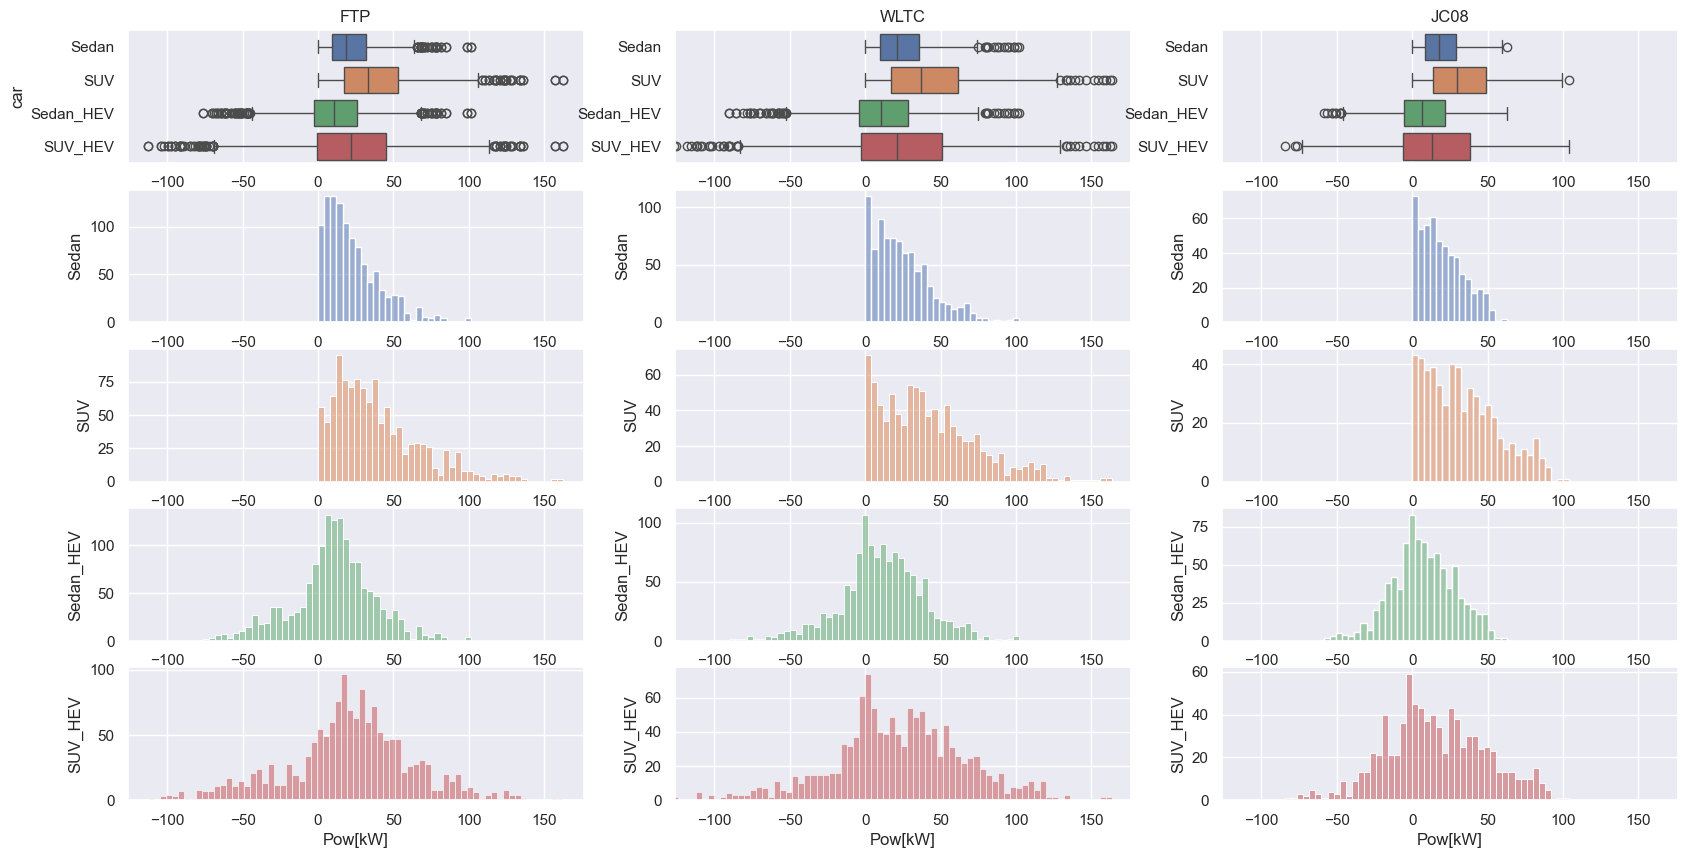

In [160]:
#plotting the power consumption of each car on each cycle:

figure, axis = plt.subplots(5, 3, figsize=(20,10))

for i, cycle in enumerate(df3['cycle'].unique()):
    sns.boxplot(data=df3.loc[(df3['cycle'] == cycle) & (df3['Pow[kW]'] != 0)], ax=axis[0, i], x="Pow[kW]", y="car", hue='car')
    axis[0, i].set_title(cycle)
    if i>0:
        axis[0, i].sharex(axis[0, 0])
        axis[0, i].set_ylabel('')
    
    for j, car in enumerate(df3['car'].unique()):
        sns.histplot(data=df3.loc[ (df3['cycle'] == cycle) & (df3['car'] == car) & (df3['Pow[kW]'] != 0) ], x="Pow[kW]", ax=axis[j+1, i], binwidth=4, hue=df3['car'], legend=False)
        axis[j+1, i].set_ylabel(car)
        axis[j+1, i].sharex(axis[0, 0])

plt.draw()

We can see that for the hybrid vehicles, there's a significant amount of energy being recovered (all the bars where Pow<0).  
On non-hybrid vehicles, all this energy is wasted on brakes.

---

## Energy comsumption:

Calculating the total energy consumed by each car on each cycle:

> E(MJ) = ( P(kW)/1000 * t(s) ) / 1e+06

In [161]:
energy2 = cars2.copy()
for i, cycle in enumerate(df3['cycle'].unique()):
    for j, car in enumerate(df3['car'].unique()):
        e = round((df3.loc[(df3['car'] == energy2.index[j]) & (df3['cycle'] == cycle)]['Pow[kW]']*1000).sum()/1e+06, 2)
        energy2.loc[car, cycle] = e

energy2

,type,mass[kg],area[m2],Crr,Cd,hybrid,FTP,WLTC,JC08
Sedan,Sedan,1300,2.2,0.010,0.32,False,24.82,21.47,10.53
SUV,SUV,2000,2.7,0.015,0.45,False,44.31,38.23,18.58
Sedan_HEV,Sedan,1300,2.2,0.010,0.32,True,15.22,13.70,6.18
SUV_HEV,SUV,2000,2.7,0.015,0.45,True,31.02,27.65,12.84


In [162]:
#rearrange the above table to better plot it
en2 = energy2.reset_index().melt(id_vars=['index', 'type', 'mass[kg]', 'area[m2]', 'Crr', 'Cd', 'hybrid'], var_name='cycle', value_name='energy')
en2

,index,type,mass[kg],area[m2],Crr,Cd,hybrid,cycle,energy
0,Sedan,Sedan,1300,2.2,0.010,0.32,False,FTP,24.82
1,SUV,SUV,2000,2.7,0.015,0.45,False,FTP,44.31
2,Sedan_HEV,Sedan,1300,2.2,0.010,0.32,True,FTP,15.22
3,SUV_HEV,SUV,2000,2.7,0.015,0.45,True,FTP,31.02
4,Sedan,Sedan,1300,2.2,0.010,0.32,False,WLTC,21.47
5,SUV,SUV,2000,2.7,0.015,0.45,False,WLTC,38.23
6,Sedan_HEV,Sedan,1300,2.2,0.010,0.32,True,WLTC,13.70
7,SUV_HEV,SUV,2000,2.7,0.015,0.45,True,WLTC,27.65
8,Sedan,Sedan,1300,2.2,0.010,0.32,False,JC08,10.53
9,SUV,SUV,2000,2.7,0.015,0.45,False,JC08,18.58


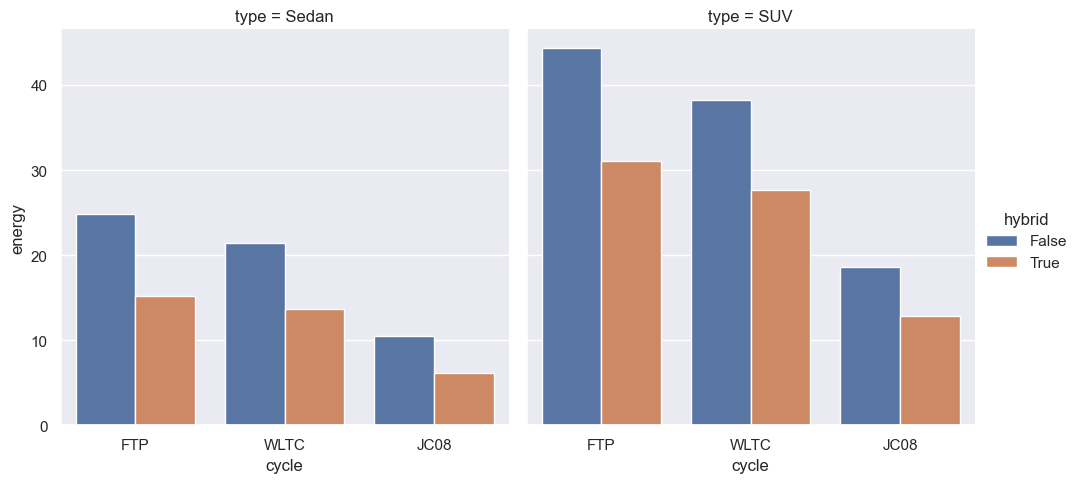

In [163]:
sns.catplot(data=en2, x='cycle', y='energy', hue='hybrid', col='type', kind='bar')

# Conclusion and observations

We can see a reduction in energy consumption in the order of 30-40% on the hybrid cars compared with the non-hybrid ones. This is the amount of energy being wasted on braking, wich is recovered on the hybrid vehicles.

Of course this is a very simplistic analysis. We are looking at the power/work on the vehicles' wheels, so totaly ignoring the engine and transmission efficiency. Also we are considering that all the braking energy can be recovered on the hybrid vehicles, what is not the reality. These and other simplifications could be included in the calculations, increasing the complexity - and the precision - of the analysis, but this is beyond the scope of this little project.